In [1]:
import random
from enum import Enum, unique
from typing import List

import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
from PIL import Image
from tensorboardX import SummaryWriter
from torch.multiprocessing import freeze_support
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed


sns.set_style()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.family"] = "Rubik"
sns.set_context("paper")


from pit.dynamics.kinematic_bicycle import Bicycle
from pit.dynamics.unicycle import Unicycle
from pit.integration import Euler, RK4
from vmp.data_utils import get_map_points, TraceRelativeDataset, centerline, map_x, map_y
from vmp.utils import Method, DynamicModel, Curvature, frenet_to_point, point_to_frenet, get_interpolated_point
from vmp.viz_utils import create_debug_plot, create_single_plot
from vmp.networks import LSTMPredictorPCMP, LSTMPredictor, get_model
from vmp.losses import *
from vmp.data_utils import TraceRelativeDataset, TRAIN_LIST, VAL_LIST, TEST_LIST, RACE_TEST_LIST, map_x, map_y, CAR_LENGTH, CAR_WIDTH
from toy_problem_library import test_model

In [2]:
def rad_to_deg(radians):
    return radians*57.29578

In [3]:
DEVICE = 'cuda:1'

In [4]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
val_frame = pd.read_pickle("../../data/val_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
full_frame = pd.read_pickle("../../data/final_data.pkl")
no_race_val_frame = val_frame[
    val_frame["selected_lane"].apply(
        lambda x: True if x in ["left", "center", "right"] else False
    )
]
race_val_frame = val_frame[
    val_frame["selected_lane"].apply(
        lambda x: True if x in ["race"] else False
    )
]
no_race_test_frame = test_frame[
    test_frame["selected_lane"].apply(
        lambda x: True if x in ["left", "center", "right"] else False
    )
]
race_test_frame = test_frame[
    test_frame["selected_lane"].apply(lambda x: True if x in ["race"] else False)
]

In [5]:
train_dataset = TraceRelativeDataset(train_frame, curve=True, random_noise=True)
test_dataset = TraceRelativeDataset(test_frame, curve=True, random_noise=True)
val_dataset = TraceRelativeDataset(val_frame, curve=True, random_noise=True)
no_race_val_dataset = TraceRelativeDataset(no_race_val_frame, curve=True, random_noise=True)
race_val_dataset = TraceRelativeDataset(race_val_frame, curve=True, random_noise=True)
no_race_test_dataset = TraceRelativeDataset(no_race_test_frame, curve=True, random_noise=True)
race_test_dataset = TraceRelativeDataset(race_test_frame, curve=True, random_noise=True)
#debug_dataset = TraceRelativeDataset(val_frame[:512], curve=True)
#debug_dataloader = DataLoader(debug_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)
no_race_val_dataloader = DataLoader(no_race_val_dataset, batch_size=1024, shuffle=True)
race_val_dataloader = DataLoader(race_val_dataset, batch_size=1024, shuffle=True)
no_race_test_dataloader = DataLoader(no_race_test_dataset, batch_size=1024, shuffle=True)
race_test_dataloader = DataLoader(race_test_dataset, batch_size=1024, shuffle=True)

In [6]:
path_root = "runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5/"
#path_root = "runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS/"

meta = torch.load(path_root+"last_model_meta.pt")
config = meta['config']
net, optimizer, directory, config_dict = get_model(config)
config_dict["DEVICE"] = DEVICE
net.load_state_dict(torch.load(path_root+"last_model.pt"))
net.to(DEVICE)
net.eval()
for input, last_pose, target in train_dataloader:
    break
display(input.shape)
display(last_pose.shape)
display(target.shape)
input = input.to(DEVICE)
last_pose = last_pose.to(DEVICE)
other_outp, other_outp_control = net.predict(input, last_pose)
#other_outp = net.predict(input, last_pose)
other_outp.shape

torch.Size([1024, 10, 10])

torch.Size([1024, 4])

torch.Size([1024, 60, 3])

torch.Size([1024, 60, 4])

In [7]:
meta['epoch']

349

In [8]:
meta['config']

{'hidden_dim': 16,
 'epochs': 350,
 'control_outputs': 60,
 'curriculum': True,
 'eps_per_input': 2,
 'prefix': 'runs/final-toy/performance-comparison/',
 'batch_size': 512,
 'DEVICE': 'cuda:1',
 'wheelbase': 0.3302,
 'residual': False,
 'model': <DynamicModel.BICYCLE: 0>,
 'robustness': False,
 'wd': 1e-05,
 'lr': 0.001,
 'momentum': 0.8,
 'horizon': 60,
 'timestep': 0.01,
 'loss_func': 'custom',
 'save_all': True,
 'method': <Method.PIMP: 0>,
 'curvature': <Curvature.CURVATURE: 1>,
 'job_id': 5,
 'output_queue': None,
 'pytorch_total_params': 5505}

0.4175071716308594

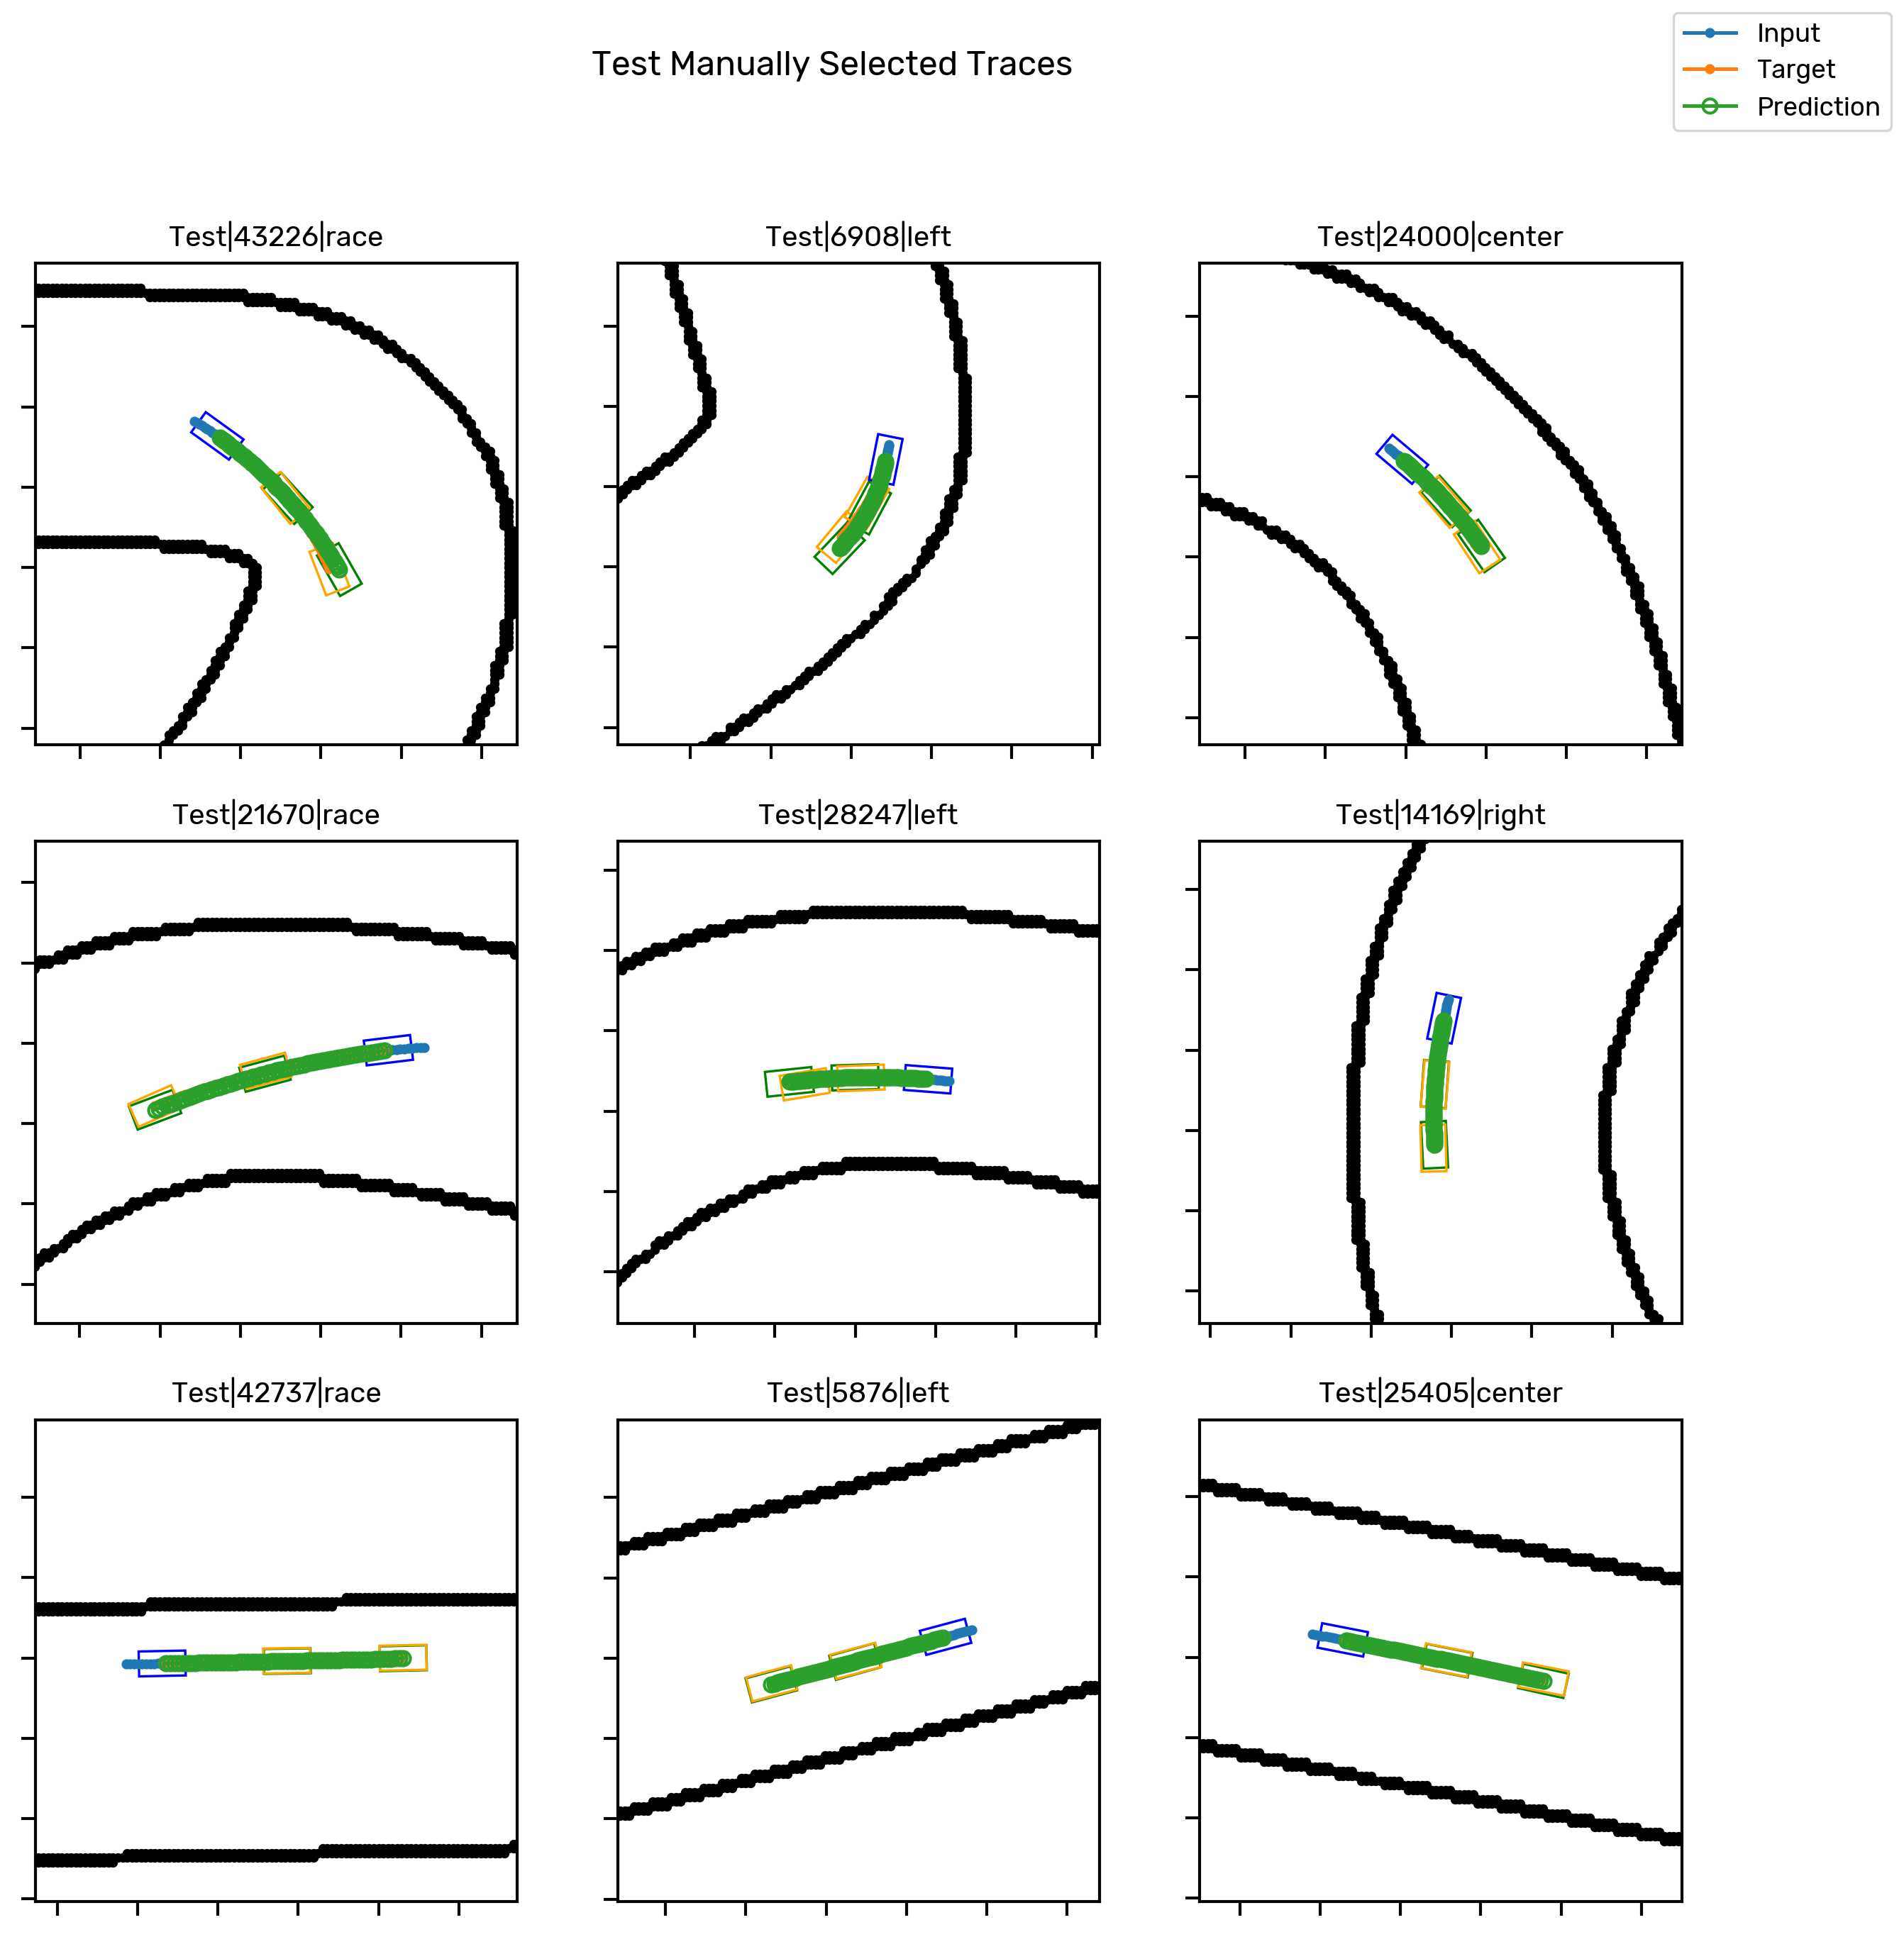

In [9]:
import time
start = time.time()
create_debug_plot(
    net, 
    train_dataset=train_dataloader.dataset, 
    test_dataset=test_dataloader.dataset, 
    val_dataset=val_dataloader.dataset, 
    curvature=config['curvature'], 
    DEVICE=DEVICE, 
    full_frame=full_frame, 
    dataset_name="test"
)
end = time.time()
end-start

In [10]:
def get_metric_distribution(path, samples=30, dataloader=test_dataloader, dataset_name='test'):
    from vmp.utils import set_seed
    meta = torch.load(path+"last_model_meta.pt")
    config = meta['config']
    net, optimizer, directory, config_dict = get_model(config)
    config_dict["DEVICE"] = DEVICE
    net.load_state_dict(torch.load(path+"last_model.pt"))
    net.to(DEVICE)
    net.eval()

    ades = list()
    fdes = list()
    head_errs = list()
    iou_errs = list()

    for i in tqdm(range(samples)):
        ade, fde, cum_head_err, iou_err, cum_test_loss, test_fig, end_index, element_results = test_model(
            config_dict=config_dict,
            net=net,
            dataloader=dataloader,
            loss_func=custom_loss_func,
            epoch=350,
            curriculum_steps=1,
            dataset_name=dataset_name,
            histogram_results=True,
            iou=True,
            image=False,
            seed=i,
        )
        ades.append(ade)
        fdes.append(fde)
        head_errs.append(cum_head_err)
        iou_errs.append(iou_err)
    return {
        'path': path,
        'ades': ades,
        'fdes': fdes,
        'heading_errors': head_errs,
        'iou_errors': iou_errs,
        'training_loss': meta['train_losses'][-1],
    }


In [11]:
get_metric_distribution("runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/", 3, dataloader=race_test_dataloader, dataset_name='race_test')

  0%|          | 0/3 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in

{'path': 'runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/',
 'ades': [0.263644970946051, 0.2663420568058147, 0.26894755956545396],
 'fdes': [0.7605324816347948, 0.7660478126943407, 0.7748056592039801],
 'heading_errors': [0.008749765424586053,
  0.008803454916275556,
  0.008814322058834246],
 'iou_errors': [0.4310953168726679, 0.43108116643345773, 0.4330868849113806],
 'training_loss': 0.044995291921485395}

In [12]:
get_metric_distribution("runs/final-toy/robustness/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0/", 3, dataloader=race_test_dataloader, dataset_name='race_test')

  0%|          | 0/3 [00:00<?, ?it/s]

{'path': 'runs/final-toy/robustness/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0/',
 'ades': [0.14959325078708022, 0.14981905049945585, 0.14936649455359918],
 'fdes': [0.2983477388448383, 0.29859072557136196, 0.2980743863689366],
 'heading_errors': [0.0010394526951348604,
  0.0010427638665953679,
  0.001040181473119935],
 'iou_errors': [0.5318840368470149, 0.5314654146260883, 0.5326623717350746],
 'training_loss': 0.0015058619653665337}

In [13]:
from joblib import Parallel, delayed
import datetime
jobs = [
    "runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/",
    "runs/final-toy/robustness/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0/",
    "runs/final-toy/robustness/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1/",
    "runs/final-toy/robustness/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2/",
]
#results = Parallel(n_jobs=5, verbose=10)(delayed(get_metric_distribution)(i, 3) for i in jobs)
results =[get_metric_distribution(i, dataloader=race_test_dataloader, dataset_name='race_test') for i in jobs]

#pimp_curr_2 = get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS/")
#pimp_no_curr = get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS/")
#lstm = get_metric_distribution("runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS/")
print(results[0]['path'])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/


In [14]:
import pathlib
for res in results:
    res['name'] = pathlib.PurePath(res['path']).name

In [15]:
str(results[0]['name'])

'CTRV-60-P0-0.001-0'

In [16]:
[res['name'] for res in results]

['CTRV-60-P0-0.001-0',
 'LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0',
 'PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1',
 'PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2']

In [17]:
from scipy import stats

<AxesSubplot: >

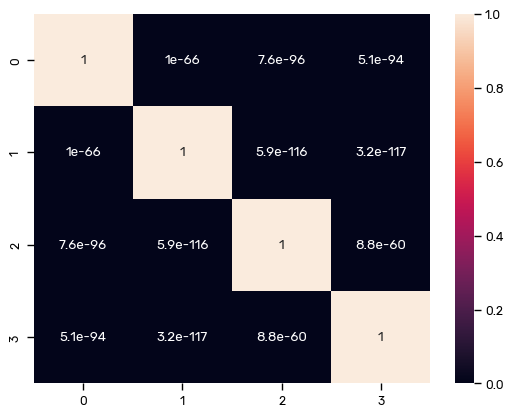

In [18]:
metric = 'iou_errors'
statistics = np.zeros((4, 4))
pvalues = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        stat, pval = stats.ttest_ind(results[i][metric], results[j][metric])
        statistics[i, j] = stat
        pvalues[i, j] = pval
sns.heatmap(pvalues, annot=True)

<AxesSubplot: >

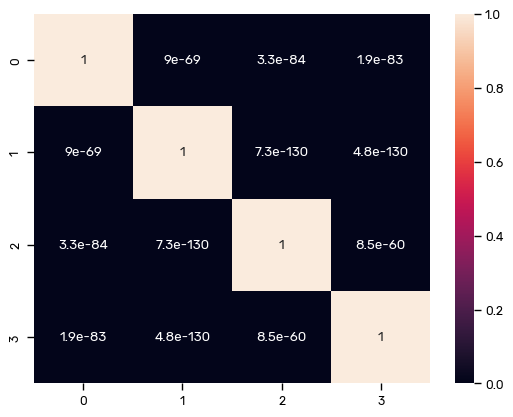

In [19]:
metric = 'ades'
statistics = np.zeros((4, 4))
pvalues = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        stat, pval = stats.ttest_ind(results[i][metric], results[j][metric])
        statistics[i, j] = stat
        pvalues[i, j] = pval
sns.heatmap(pvalues, annot=True)

<AxesSubplot: >

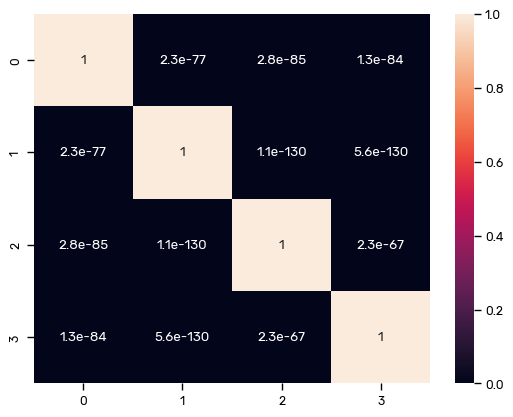

In [20]:
metric = 'fdes'
statistics = np.zeros((4, 4))
pvalues = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        stat, pval = stats.ttest_ind(results[i][metric], results[j][metric])
        statistics[i, j] = stat
        pvalues[i, j] = pval
sns.heatmap(pvalues, annot=True)

In [21]:
metric='ades'
print(metric)
for res in results:
    print(f"{res['name']:<70}  MEAN: {np.mean(res[metric]):4f}  STDDEV: {np.std(res[metric]):4f}")

ades
CTRV-60-P0-0.001-0                                                      MEAN: 0.267870  STDDEV: 0.005842
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                             MEAN: 0.149614  STDDEV: 0.000269
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1     MEAN: 0.049131  STDDEV: 0.000347
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2     MEAN: 0.055657  STDDEV: 0.000306


In [22]:
metric='fdes'
print(metric)
for res in results:
    print(f"{res['name']:<70}  MEAN: {np.mean(res[metric]):4f}  STDDEV: {np.std(res[metric]):4f}")

fdes
CTRV-60-P0-0.001-0                                                      MEAN: 0.771728  STDDEV: 0.016616
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                             MEAN: 0.298383  STDDEV: 0.000314
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1     MEAN: 0.122928  STDDEV: 0.000671
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2     MEAN: 0.140278  STDDEV: 0.000611


In [23]:
metric='iou_errors'
print(metric)
for res in results:
    print(f"{res['name']:<70}  MEAN: {np.mean(res[metric]):4f}  STDDEV: {np.std(res[metric]):4f}")

iou_errors
CTRV-60-P0-0.001-0                                                      MEAN: 0.430611  STDDEV: 0.005369
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                             MEAN: 0.531767  STDDEV: 0.000811
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1     MEAN: 0.762215  STDDEV: 0.001548
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2     MEAN: 0.734437  STDDEV: 0.001216


In [24]:
print(f"{'':<68}  MEAN: \t  STDDEV: ")
for res in results:
    print(f"{res['name']:<68}  ${np.mean(res['ades']):.4f} \pm \\num{{{np.std(res['ades']):.1e}}}$ & ${np.mean(res['fdes']):.4f} \pm \\num{{{np.std(res['fdes']):.1e}}}$ & ${np.mean(res['iou_errors']):.4f} \pm \\num{{{np.std(res['iou_errors']):.1e}}}$")

                                                                      MEAN: 	  STDDEV: 
CTRV-60-P0-0.001-0                                                    $0.2679 \pm \num{5.8e-03}$ & $0.7717 \pm \num{1.7e-02}$ & $0.4306 \pm \num{5.4e-03}$
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           $0.1496 \pm \num{2.7e-04}$ & $0.2984 \pm \num{3.1e-04}$ & $0.5318 \pm \num{8.1e-04}$
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   $0.0491 \pm \num{3.5e-04}$ & $0.1229 \pm \num{6.7e-04}$ & $0.7622 \pm \num{1.5e-03}$
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   $0.0557 \pm \num{3.1e-04}$ & $0.1403 \pm \num{6.1e-04}$ & $0.7344 \pm \num{1.2e-03}$


In [31]:
print(f"{'':<68}  MEAN:")
for res in results:
    print(f"{res['name']:<68}  ${np.mean(res['ades']):.4f}$ & ${np.mean(res['fdes']):.4f}$ & ${np.mean(res['iou_errors']):.4f}$")

                                                                      MEAN:
CTRV-60-P0-0.001-0                                                    $0.2679$ & $0.7717$ & $0.4306$
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           $0.1496$ & $0.2984$ & $0.5318$
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   $0.0491$ & $0.1229$ & $0.7622$
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   $0.0557$ & $0.1403$ & $0.7344$


In [25]:
from joblib import Parallel, delayed
import datetime
jobs = [
    "runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/",
    "runs/final-toy/robustness/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0/",
    "runs/final-toy/robustness/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1/",
    "runs/final-toy/robustness/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2/",
]
#results = Parallel(n_jobs=5, verbose=10)(delayed(get_metric_distribution)(i, 3) for i in jobs)
tresults =[get_metric_distribution(i, dataloader=no_race_test_dataloader, dataset_name='race_test') for i in jobs]

#pimp_curr_2 = get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS/")
#pimp_no_curr = get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS/")
#lstm = get_metric_distribution("runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS/")
print(tresults[0]['path'])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/


In [26]:
import pathlib
for res in tresults:
    res['name'] = pathlib.PurePath(res['path']).name

In [27]:
metric='ades'
print(metric)
print(f"{'':<68}  MEAN: \t  STDDEV: ")
for res in tresults:
    print(f"{res['name']:<68}  {np.mean(res[metric]):4f} \pm {np.std(res[metric]):4f}")

ades
                                                                      MEAN: 	  STDDEV: 
CTRV-60-P0-0.001-0                                                    0.254088 \pm 0.002569
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           0.076358 \pm 0.000139
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   0.054923 \pm 0.000184
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   0.061097 \pm 0.000181


In [28]:
metric='fdes'
print(metric)
print(f"{'':<68}  MEAN: \t  STDDEV: ")
for res in tresults:
    print(f"{res['name']:<68}  {np.mean(res[metric]):4f} \pm {np.std(res[metric]):4f}")

fdes
                                                                      MEAN: 	  STDDEV: 
CTRV-60-P0-0.001-0                                                    0.732188 \pm 0.007384
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           0.147052 \pm 0.000171
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   0.134230 \pm 0.000360
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   0.150091 \pm 0.000344


In [29]:
metric='iou_errors'
print(metric)
print(f"{'':<68}  MEAN: \t  STDDEV: ")
for res in tresults:
    print(f"{res['name']:<68}  {np.mean(res[metric]):4f} \pm {np.std(res[metric]):4f}")

iou_errors
                                                                      MEAN: 	  STDDEV: 
CTRV-60-P0-0.001-0                                                    0.437306 \pm 0.002740
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           0.685293 \pm 0.000498
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   0.768312 \pm 0.000870
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   0.735270 \pm 0.000835


In [30]:
metric='iou_errors'
print(metric)
print(f"{'':<68}  MEAN: \t  STDDEV: ")
for res in tresults:
    print(f"{res['name']:<68}  ${np.mean(res['ades']):.4f} \pm \\num{{{np.std(res['ades']):.1e}}}$ & ${np.mean(res['fdes']):.4f} \pm \\num{{{np.std(res['fdes']):.1e}}}$ & ${np.mean(res['iou_errors']):.4f} \pm \\num{{{np.std(res['iou_errors']):.1e}}}$")

iou_errors
                                                                      MEAN: 	  STDDEV: 
CTRV-60-P0-0.001-0                                                    $0.2541 \pm \num{2.6e-03}$ & $0.7322 \pm \num{7.4e-03}$ & $0.4373 \pm \num{2.7e-03}$
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           $0.0764 \pm \num{1.4e-04}$ & $0.1471 \pm \num{1.7e-04}$ & $0.6853 \pm \num{5.0e-04}$
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   $0.0549 \pm \num{1.8e-04}$ & $0.1342 \pm \num{3.6e-04}$ & $0.7683 \pm \num{8.7e-04}$
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   $0.0611 \pm \num{1.8e-04}$ & $0.1501 \pm \num{3.4e-04}$ & $0.7353 \pm \num{8.4e-04}$
